In [1]:
import glob, os, sys, re, random
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ete3
from ete3 import PhyloTree
from Bio import SeqIO
import tqdm

To run this notebook you need to download MIDORI2 database (https://www.reference-midori.info/):
- MIDORI2_UNIQ_NUC_GB259_{GeneName}_BLAST.fasta.zip
- MIDORI2_LONGEST_AA_GB259_{GeneName}_BLAST.fasta.zip

## Chordata *amino acids*

In [2]:
# collect how many nucleotide sequences in the MIDORI for each gene (simple filtration)

def collect_seqs(pattern: str, genes: list, sp=False):
    directory = "../data/MIDORI2/"
    file = "MIDORI2_UNIQ_NUC_GB259_{}_BLAST.fasta"
    path_to_fasta = directory + file
    seqs = defaultdict(list)
    for gene in tqdm.tqdm(genes, "Gene"):
        inp = path_to_fasta.format(gene)
        for rec in SeqIO.parse(inp, "fasta"):
            header = rec.description
            
            if pattern not in header:
                continue

            raw_acc, taxa = header.split("###")
            acc, place = re.match("(\w+\.\d)\.(.+)", raw_acc).groups()
            taxa = taxa.removeprefix("root_1;Eukaryota_2759;")
            species = " ".join(taxa.split(";")[-1].split("_")[:-1])
            # change header to more usable format
            rec.id = acc
            rec.description = f"{species} {place} ###{taxa}"
            seqs[gene + "__" + species.replace(" ", "_")].append(rec)
    return seqs


phylum = "Chordata"
genes = ['A6', 'A8', 'CO1', 'CO2', 'CO3', 'Cytb', 'ND1', 'ND2', 'ND3', 'ND4', 'ND4L', 'ND5', 'ND6']
seqs_nuc_chordata = collect_seqs(phylum, genes)

Gene: 100%|██████████| 13/13 [00:26<00:00,  2.06s/it]


In [11]:
str(len(seqs_nuc_chordata)) + ' mt genes in chordates species'

'208867 mt genes in chordates species'

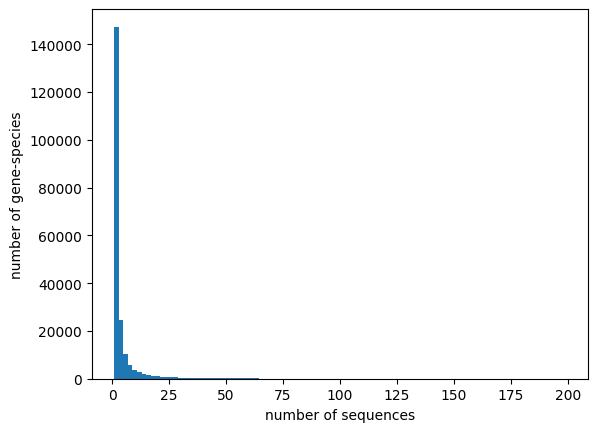

In [7]:
plt.hist([len(v) for _,v in seqs_nuc_chordata.items() if len(v) < 200], bins=100);
plt.xlabel('number of sequences');
plt.ylabel('number of gene-species');

In [10]:
# number of unique species
len(set([x.split('__')[1] for x in seqs_nuc_chordata.keys()]))

49461

In [12]:
# number of unique species for each gene
Counter([x.split('__')[0] for x in seqs_nuc_chordata.keys()])

Counter({'Cytb': 33962,
         'CO1': 33506,
         'ND2': 23602,
         'ND4': 14985,
         'ND3': 12754,
         'ND1': 12684,
         'A6': 12543,
         'A8': 12033,
         'CO2': 10931,
         'ND5': 10789,
         'CO3': 10428,
         'ND4L': 10350,
         'ND6': 10300})

In [15]:
# prepare inputs for NeMu-pipeline (it accepts single protein sequence)
genes = ['A6', 'A8', 'CO1', 'CO2', 'CO3', 'Cytb', 'ND1', 'ND2', 'ND3', 'ND4', 'ND4L', 'ND5', 'ND6']
path_to_fasta = "../data/MIDORI2/AA/MIDORI2_LONGEST_AA_GB259_{}_BLAST.fasta"
seqs_all = defaultdict(list)
data = []

npassed = 0
for gene in tqdm.tqdm(genes):
    inp = path_to_fasta.format(gene)
    for rec in SeqIO.parse(inp, "fasta"):
        header = rec.description

        # only chordates
        if phylum not in header:
            npassed += 1
            continue

        raw_acc, taxa = header.split("###")
        acc, place = re.match("(\w+\.\d)\.(.+)", raw_acc).groups()
        taxa = taxa.removeprefix("root_1;Eukaryota_2759;")
        species = " ".join(taxa.split(";")[-1].split("_")[:-1])
        gene_species = gene + "__" + species.replace(" ", "_")
        
        # filter out seuqences of gene-species with complex species names and that 
        # contain less than 10 nucleotide sequences 
        if species.count(' ') > 2 or len(seqs_nuc_chordata[gene_species]) < 10:
            npassed += 1
            continue

        # collect only 
        rec.id = acc
        rec.description = f"{species} {place} ###{taxa}"
        seqs_all[gene_species].append(rec)
        data.append([
            raw_acc, gene, taxa, species
        ])

df = pd.DataFrame(data, columns=['acc', 'gene', 'taxa', 'species'])
print(f'npassed = {npassed}')

100%|██████████| 13/13 [00:09<00:00,  1.30it/s]

npassed = 601534


In [16]:
# number of species for each gene in final sample for NeMu input
df.gene.value_counts()

CO1     6697
Cytb    6150
ND2     2170
ND4      988
A6       574
ND1      480
ND5      414
ND3      286
CO3      277
ND6      267
CO2      261
A8       223
ND4L     150
Name: gene, dtype: int64

In [17]:
df 

,acc,gene,taxa,species
0,AB478558.1.8820.9502_BAH86124.1,A6,Chordata_7711;Leptocardii_2682552;Amphioxiform...,Branchiostoma belcheri
1,AB478590.1.8806.9488_BAH86540.1,A6,Chordata_7711;Leptocardii_2682552;Amphioxiform...,Branchiostoma floridae
2,Y09525.1.238.>921_CAA70712.1,A6,Chordata_7711;Leptocardii_2682552;Amphioxiform...,Branchiostoma lanceolatum
3,KP722183.1.159.>838_AJV90905.1,A6,Chordata_7711;Hyperoartia_117569;Petromyzontif...,Lampetra fluviatilis
4,FR669668.2.1432.>2101_CBW30998.1,A6,Chordata_7711;Hyperoartia_117569;Petromyzontif...,Lampetra planeri
...,...,...,...,...
18932,KY676708.1.1.519_AVM18678.1,ND6,Chordata_7711;Amphibia_8292;Caudata_8293;Pleth...,Eurycea braggi
18933,KY676695.1.1.519_AVM18665.1,ND6,Chordata_7711;Amphibia_8292;Caudata_8293;Pleth...,Eurycea spelaea
18934,EU880310.1.14048.13530_ACJ43568.1,ND6,Chordata_7711;Amphibia_8292;Caudata_8293;Salam...,Cynops ensicauda
18935,EU880313.1.14046.13528_ACJ43607.1,ND6,Chordata_7711;Amphibia_8292;Caudata_8293;Salam...,Cynops pyrrhogaster


In [18]:
# save all sequences in separate fasta files to run NeMu-pipeline in advanced mode
outdir = '../data/chordata2/input'
for gene_species, rec in tqdm.tqdm(seqs_all.items()):
    gene, _ = gene_species.split('__')
    gdir = f'{outdir}/{gene}'
    if not os.path.exists(gdir):
        os.mkdir(gdir)
        
    SeqIO.write(rec, f'{gdir}/{gene_species}.fasta', 'fasta-2line')

100%|██████████| 18937/18937 [00:16<00:00, 1126.53it/s]


In [19]:
# save metainformation about prepared sequences (taxonomy and ID)
df.to_csv('../data/chordata2/info.csv', index=False)